/tmp/ipykernel_23418/3475442941.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(inputs_[:, 0], inputs_[:, 1], c=colors, cmap=matplotlib.cm.get_cmap('RdYlBu'))


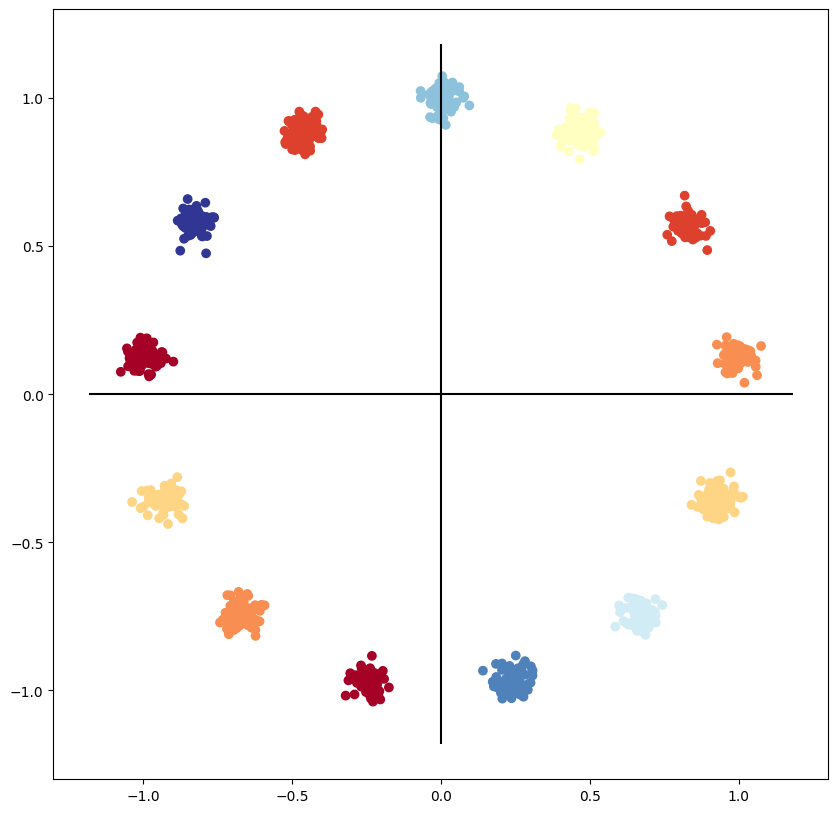

In [1]:
import os, sys, numpy, torch, matplotlib.pyplot, matplotlib.cm, ipycanvas, matplotlib.patches

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from functools import partial
from utils.optimization import initialize, ExponentialLoss
from utils.plots import plot_train_loss, plot_samples_and_neurons, draw_figure_into_canvas, save_figure
from settings.sphere_2d_epsilon_net import get_clusters_means_and_labels
from settings.gaussian_clusters import get_dataloader
from experiment import execute_experiment
from models import Growing2LayerReLUNN

experiment = {
    'dataset': 'sphere_2d_epsilon_net',
    'epsilon': .25,
    'net_epsilon': .2e-5,
    'seed': 3,
    'input_dimension': 2, 
    'sample_size': 1000,  
    'batch_size': 100, 
    'within_cluster_variance': 0.001,
    'epochs': 100,
    'learning_rate': .1,
    'bias': False,
    'name_parameters': ['seed'],
    #'balance_classes': True,
    'initialization_scale': 1.e-5,
    'new_neurons_per_iteration': 100,
    'new_classes_per_iteration': 3, 
    'classes': 9,
    'random_clusters_label_assignment': True
    #'initial_weights': [
    #    [[0., 1e-5], [0., -1e-5], [-(.25**.5)*1e-5, -(7.5**.5)*1e-5], [(.5**.5)*1e-5, -(.5**.5)*1e-5], [-(.15**.5)*1e-5, -(.85**.5)*1e-5]]
    #],
    #'output_layer_initial_weights': [-1e-5, 1e-5, 1e-5, 1e-5, 1e-5]
}
rotation_matrix = numpy.identity(experiment['input_dimension'])
device, generator = initialize(experiment['seed'])
clusters_means, clusters_labels = get_clusters_means_and_labels(**experiment)
train_data = get_dataloader(**experiment, clusters_means=clusters_means, clusters_labels=clusters_labels, 
                            rotation_matrix=rotation_matrix, generator=generator)
test_data = get_dataloader(**experiment, clusters_means=clusters_means, clusters_labels=clusters_labels, 
                            rotation_matrix=rotation_matrix, generator=generator)


#X =[[2**-.5, 2**-.5], [2**-.5, -2**-.5],] + [[1, 0],] * 2
##X =[[1., 1.], [1., -1.],] + [[1., 0.],] * 2
#y = [0, 0, ] + [1, ] * 2
#
#with torch.no_grad():
#    tensor_X = torch.Tensor(X)
#    tensor_y = torch.Tensor(y)
#
#dataset = torch.utils.data.TensorDataset(tensor_X, tensor_y)
#train_data = test_data = torch.utils.data.DataLoader(dataset, len(X), shuffle=True)

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs = []; labels = []
for batch_inputs, batch_labels in train_data: inputs.append(batch_inputs); labels.append(batch_labels)
inputs, labels = torch.concatenate(inputs), torch.concatenate(labels)
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
colors = numpy.argmax(labels, axis=1) if experiment['classes'] > 2 else labels
ax.hlines(0, -inputs_.max() * 1.1, inputs_.max() * 1.1, color='k')
ax.vlines(0, -inputs_.max() * 1.1, inputs_.max() * 1.1, color='k')
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=colors, cmap=matplotlib.cm.get_cmap('RdYlBu'))
#nodes = sphere_2d_epsilon_net(**experiment)
#ax.add_patch(matplotlib.patches.Circle([0, 0], 1, color='k', alpha=.1, fill=False))
#for node in nodes:
#    ax.add_patch(matplotlib.patches.Circle(node, experiment['epsilon'], color='k', alpha=.05))

In [2]:
matplotlib.pyplot.ioff()
figure, (input_domain_ax, loss_ax) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 8))

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1000, 500
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)

plot_samples_and_neurons = partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
plot_train_loss = partial(plot_train_loss, ax=loss_ax)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)

canvas

Canvas(width=1000)

In [3]:
experiment, model, device, generator = execute_experiment(
    **experiment,
    train_data=train_data, 
    test_data=test_data, 
    model_class=Growing2LayerReLUNN,
    train_loss_class=ExponentialLoss,
    saving_epochs_interval=experiment['epochs'],
    callbacks_epochs=list(range(0, experiment['epochs'] * (experiment['classes'] // experiment['new_classes_per_iteration'] + 1), 10)),
    callbacks=[plot_samples_and_neurons,
               plot_train_loss, 
               draw_figure_into_canvas, save_figure],
    overwrite=True,
    backbone=torch.nn.Identity()
)

Learning iteration 0. Classes to learn: [0, 1, 2]


/workspaces/nns_growth/notebooks/continual_learning/models.py:112: OptimizeWarning: x0 is used only when method is 'revised simplex'. 
  final_solution = scipy.optimize.linprog(c, x0=initial_solution, A_ub=A, b_ub=b).x


Learning iteration 1. Classes to learn: [3, 4, 5]
Learning iteration 2. Classes to learn: [6, 7, 8]
Learning iteration 3. Classes to learn: []


In [4]:
from experiment import extract_samples
from utils.optimization import accuracy

test_inputs, test_labels = extract_samples(test_data)
accuracy(model(test_inputs), test_labels)

tensor(0.1640)

In [8]:
from experiment import extract_samples
from utils.optimization import accuracy

test_inputs, test_labels = extract_samples(test_data)
accuracy(model(test_inputs), test_labels)

tensor(0.4590)

In [5]:
matplotlib.pyplot.ioff()
figure, (input_domain_ax, loss_ax) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 8))

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1000, 500
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)

plot_samples_and_neurons = partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
plot_train_loss = partial(plot_train_loss, ax=loss_ax)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)

canvas

Canvas(width=1000)

In [7]:
experiment = {
    'dataset': 'sphere_2d_epsilon_net',
    'epsilon': .25,
    'net_epsilon': .2e-5,
    'seed': 3,
    'input_dimension': 2, 
    'sample_size': 1000,  
    'batch_size': 100, 
    'within_cluster_variance': 0.001,
    'epochs': 300,
    'learning_rate': .1,
    'bias': False,
    'name_parameters': ['seed'],
    #'balance_classes': True,
    'initialization_scale': 1.e-5,
    'new_neurons_per_iteration': 100,
    'new_classes_per_iteration': 9, 
    'classes': 9,
    #'initial_weights': [
    #    [[0., 1e-5], [0., -1e-5], [-(.25**.5)*1e-5, -(7.5**.5)*1e-5], [(.5**.5)*1e-5, -(.5**.5)*1e-5], [-(.15**.5)*1e-5, -(.85**.5)*1e-5]]
    #],
    #'output_layer_initial_weights': [-1e-5, 1e-5, 1e-5, 1e-5, 1e-5]
}

experiment, model, device, generator = execute_experiment(
    **experiment,
    train_data=train_data, 
    test_data=test_data, 
    model_class=Growing2LayerReLUNN,
    train_loss_class=ExponentialLoss,
    saving_epochs_interval=experiment['epochs'],
    callbacks_epochs=list(range(0, experiment['epochs'] * (experiment['classes'] // experiment['new_classes_per_iteration'] + 1), 10)),
    callbacks=[plot_samples_and_neurons,
               plot_train_loss, 
               draw_figure_into_canvas, save_figure],
    overwrite=True,
    backbone=torch.nn.Identity()
)

Learning iteration 0. Classes to learn: [0, 1, 2, 3, 4, 5, 6, 7, 8]


/workspaces/nns_growth/notebooks/continual_learning/models.py:112: OptimizeWarning: x0 is used only when method is 'revised simplex'. 
  final_solution = scipy.optimize.linprog(c, x0=initial_solution, A_ub=A, b_ub=b).x


Learning iteration 1. Classes to learn: []


In [9]:
matplotlib.pyplot.ioff()
figure, (input_domain_ax, loss_ax) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 8))

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1000, 500
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)

plot_samples_and_neurons = partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
plot_train_loss = partial(plot_train_loss, ax=loss_ax)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)

canvas

Canvas(width=1000)

In [10]:
experiment = {
    'dataset': 'sphere_2d_epsilon_net',
    'epsilon': .25,
    'net_epsilon': .2e-5,
    'seed': 3,
    'input_dimension': 2, 
    'sample_size': 1000,  
    'batch_size': 100, 
    'within_cluster_variance': 0.001,
    'epochs': 300,
    'learning_rate': .1,
    'bias': False,
    'name_parameters': ['seed'],
    #'balance_classes': True,
    'initialization_scale': 1.e-5,
    'new_neurons_per_iteration': 100,
    'new_classes_per_iteration': 9, 
    'classes': 9,
    #'initial_weights': [
    #    [[0., 1e-5], [0., -1e-5], [-(.25**.5)*1e-5, -(7.5**.5)*1e-5], [(.5**.5)*1e-5, -(.5**.5)*1e-5], [-(.15**.5)*1e-5, -(.85**.5)*1e-5]]
    #],
    #'output_layer_initial_weights': [-1e-5, 1e-5, 1e-5, 1e-5, 1e-5]
}

experiment, model, device, generator = execute_experiment(
    **experiment,
    train_data=train_data, 
    test_data=test_data, 
    model_class=Growing2LayerReLUNN,
    train_loss_class=ExponentialLoss,
    saving_epochs_interval=experiment['epochs'],
    callbacks_epochs=list(range(0, experiment['epochs'] * (experiment['classes'] // experiment['new_classes_per_iteration'] + 1), 10)),
    callbacks=[plot_samples_and_neurons,
               plot_train_loss, 
               draw_figure_into_canvas, save_figure],
    overwrite=True,
    backbone=torch.nn.Identity(),
    prune=False
)

Learning iteration 0. Classes to learn: [0, 1, 2, 3, 4, 5, 6, 7, 8]


/workspaces/nns_growth/notebooks/continual_learning/models.py:112: OptimizeWarning: x0 is used only when method is 'revised simplex'. 
  final_solution = scipy.optimize.linprog(c, x0=initial_solution, A_ub=A, b_ub=b).x


Learning iteration 1. Classes to learn: []


In [ ]:
outputs = model(inputs)
loss = ExponentialLoss()(outputs, labels)

activations = []
for neuron in model.neurons:
    activations.append(neuron.activations)

activations = torch.stack(activations)
labels_ = (labels * 2. - 1.).flatten()
margins = labels_ * activations.sum(dim=0).squeeze()

min_margin = margins.min()
exp_margins = torch.exp(- margins)
exp_margins_sum = exp_margins.sum()

C = (min_margin ** (1. - (1. / 2.))) * model.norm / exp_margins_sum
Lambda = 1 / C

neurons_norms = torch.tensor([neuron.norm for neuron in model.neurons])

(exp_margins * labels_) @ (activations.squeeze() / neurons_norms.unsqueeze(1)).T